In [1]:
# Dependencies
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

In [2]:
# Load data
data = pd.read_csv('transformed_data.csv', index_col=0, parse_dates=True)
# Set frequency as monthly
data = data.asfreq('MS').dropna()

In [14]:
# Correlation matrix
corr = data.corr()
cpi_corr = corr['CPIAUCSL'].sort_values(ascending=False)

# Open file to write results
f = open('feature_selection.csv', 'a')

# Select varying number of features
for num_features in range(2, 15):
    # Select features based on correlation
    corr_data = data[cpi_corr.index[0: num_features]]

    # Split into train/test
    periods = 6 # test using the last 6 months
    train_data = corr_data[:-periods].copy()
    test_data = corr_data[-periods:].copy()

    # Train the VAR model
    var_model = VAR(train_data)
    selected_lags = var_model.select_order()
    best_lag = selected_lags.aic  # Choose based on AIC or BIC
    # iterate over lags
    try:
        for lag in range(1, best_lag + 4):
            var_results = var_model.fit(lag)

            # Forecast 
            forecast = var_results.forecast(train_data.values, steps=periods)
            
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(test_data['CPIAUCSL'], forecast[:, 0]))
            print(f"Number of features: {num_features}, RMSE: {rmse}, Lags: {lag}")
            f.write(f"{num_features},{lag},{rmse},{rmse / test_data['CPIAUCSL'].mean() * 100:.2f}\n")
    except Exception as e:
        print(f"Error with {lag} lags: {e}")

# Close the file
f.close()


/home/js/macroeconvue/modeling/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/js/macroeconvue/modeling/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/js/macroeconvue/modeling/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Number of features: 2, RMSE: 0.0016035531707834525, Lags: 1
Number of features: 2, RMSE: 0.0017402249159016079, Lags: 2
Number of features: 2, RMSE: 0.0016606364671919106, Lags: 3
Number of features: 2, RMSE: 0.0015521363358766067, Lags: 4
Number of features: 2, RMSE: 0.0015027705762128757, Lags: 5
Number of features: 2, RMSE: 0.001407808625962766, Lags: 6
Number of features: 2, RMSE: 0.0014922786328944494, Lags: 7
Number of features: 2, RMSE: 0.0017297164687111127, Lags: 8
Number of features: 2, RMSE: 0.0017294340254425942, Lags: 9
Number of features: 2, RMSE: 0.0016509518547216972, Lags: 10
Number of features: 2, RMSE: 0.0017058040588987995, Lags: 11
Number of features: 2, RMSE: 0.001795122846130864, Lags: 12
Number of features: 3, RMSE: 0.0016097195303150212, Lags: 1
Number of features: 3, RMSE: 0.001753398559423068, Lags: 2
Number of features: 3, RMSE: 0.0017047519441876246, Lags: 3
Number of features: 3, RMSE: 0.0016620939126613158, Lags: 4
Number of features: 3, RMSE: 0.001619417

/home/js/macroeconvue/modeling/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Number of features: 5, RMSE: 0.0017483183552516376, Lags: 1
Number of features: 5, RMSE: 0.0019118988211903939, Lags: 2
Number of features: 5, RMSE: 0.001758937281086297, Lags: 3
Number of features: 5, RMSE: 0.0017323016338611007, Lags: 4
Number of features: 5, RMSE: 0.0016232718195134822, Lags: 5
Number of features: 5, RMSE: 0.001444330921060249, Lags: 6
Number of features: 5, RMSE: 0.0013853371633685326, Lags: 7
Number of features: 5, RMSE: 0.0015922098140947515, Lags: 8
Number of features: 5, RMSE: 0.0015016741732852379, Lags: 9
Number of features: 5, RMSE: 0.0015335419676770715, Lags: 10
Number of features: 5, RMSE: 0.0016348548627934446, Lags: 11
Number of features: 5, RMSE: 0.0016835989736297971, Lags: 12
Number of features: 5, RMSE: 0.0014529727833683282, Lags: 13
Number of features: 5, RMSE: 0.0017537248041204138, Lags: 14
Number of features: 5, RMSE: 0.0021159172397749396, Lags: 15
Number of features: 5, RMSE: 0.002517654342149775, Lags: 16


/home/js/macroeconvue/modeling/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Number of features: 6, RMSE: 0.0016829497082704453, Lags: 1
Number of features: 6, RMSE: 0.001809597965650757, Lags: 2
Number of features: 6, RMSE: 0.0016622762476607566, Lags: 3
Number of features: 6, RMSE: 0.0016532231827194048, Lags: 4
Number of features: 6, RMSE: 0.0016250296983569888, Lags: 5
Number of features: 6, RMSE: 0.0014650580808506161, Lags: 6
Number of features: 6, RMSE: 0.0014200498258769695, Lags: 7
Number of features: 6, RMSE: 0.001582690617791364, Lags: 8
Number of features: 6, RMSE: 0.0014788733007320325, Lags: 9
Number of features: 6, RMSE: 0.001571641884037487, Lags: 10
Number of features: 6, RMSE: 0.001577487473901133, Lags: 11
Number of features: 6, RMSE: 0.0015898393629548131, Lags: 12
Number of features: 6, RMSE: 0.0013726753926005, Lags: 13
Number of features: 6, RMSE: 0.0017708672680659268, Lags: 14
Number of features: 6, RMSE: 0.002324253700658813, Lags: 15
Number of features: 6, RMSE: 0.0025155924238609148, Lags: 16


/home/js/macroeconvue/modeling/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Number of features: 7, RMSE: 0.0016532809853213445, Lags: 1
Number of features: 7, RMSE: 0.0018000716195281567, Lags: 2
Number of features: 7, RMSE: 0.0017151209593936694, Lags: 3
Number of features: 7, RMSE: 0.001691433771501658, Lags: 4
Number of features: 7, RMSE: 0.0016267867754607894, Lags: 5
Number of features: 7, RMSE: 0.001430713197854354, Lags: 6
Number of features: 7, RMSE: 0.0013257729587622055, Lags: 7
Number of features: 7, RMSE: 0.0017842898688330124, Lags: 8
Number of features: 7, RMSE: 0.0016662572521507087, Lags: 9
Number of features: 7, RMSE: 0.0016887035603843574, Lags: 10
Number of features: 7, RMSE: 0.0017354148148897163, Lags: 11
Number of features: 7, RMSE: 0.001709564570882612, Lags: 12
Number of features: 7, RMSE: 0.0014102194374305478, Lags: 13
Number of features: 7, RMSE: 0.0020436997058133235, Lags: 14
Number of features: 7, RMSE: 0.0026914458365135587, Lags: 15
Number of features: 7, RMSE: 0.0030399734489187863, Lags: 16


/home/js/macroeconvue/modeling/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Number of features: 8, RMSE: 0.0016575243035143524, Lags: 1
Number of features: 8, RMSE: 0.0017831350171965492, Lags: 2
Number of features: 8, RMSE: 0.0016855703697254826, Lags: 3
Number of features: 8, RMSE: 0.0016389847034206076, Lags: 4
Number of features: 8, RMSE: 0.00164752282872609, Lags: 5
Number of features: 8, RMSE: 0.0016669748726764134, Lags: 6
Number of features: 8, RMSE: 0.0015946759720855683, Lags: 7
Number of features: 8, RMSE: 0.002228079045869307, Lags: 8
Number of features: 8, RMSE: 0.002184392808671481, Lags: 9
Number of features: 8, RMSE: 0.0021562923235954904, Lags: 10
Number of features: 8, RMSE: 0.0021583680895759763, Lags: 11
Number of features: 8, RMSE: 0.0020456586290927693, Lags: 12
Number of features: 8, RMSE: 0.0016807725802055354, Lags: 13
Number of features: 8, RMSE: 0.002314014820470064, Lags: 14
Number of features: 8, RMSE: 0.003033391213268934, Lags: 15


/home/js/macroeconvue/modeling/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Number of features: 9, RMSE: 0.0017248543536876725, Lags: 1
Number of features: 9, RMSE: 0.0017344426875554612, Lags: 2
Number of features: 9, RMSE: 0.0017082606723015674, Lags: 3
Number of features: 9, RMSE: 0.001666488248739365, Lags: 4
Number of features: 9, RMSE: 0.0016650759283583744, Lags: 5
Number of features: 9, RMSE: 0.0014345186436374464, Lags: 6
Number of features: 9, RMSE: 0.0014053436867255181, Lags: 7
Number of features: 9, RMSE: 0.0019771064139049816, Lags: 8
Number of features: 9, RMSE: 0.0021527085564651063, Lags: 9
Number of features: 9, RMSE: 0.001959117587884438, Lags: 10
Number of features: 9, RMSE: 0.002065248858324948, Lags: 11
Number of features: 9, RMSE: 0.0018476327328064723, Lags: 12
Number of features: 9, RMSE: 0.0015678003034191924, Lags: 13
Number of features: 9, RMSE: 0.00222132151883276, Lags: 14


/home/js/macroeconvue/modeling/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Number of features: 10, RMSE: 0.001749825070436168, Lags: 1
Number of features: 10, RMSE: 0.0017415740654511318, Lags: 2
Number of features: 10, RMSE: 0.00179489604706522, Lags: 3
Number of features: 10, RMSE: 0.0018013470691249872, Lags: 4
Number of features: 10, RMSE: 0.001896750128666795, Lags: 5
Number of features: 10, RMSE: 0.0016158776066677065, Lags: 6
Number of features: 10, RMSE: 0.0015260670287240228, Lags: 7
Number of features: 10, RMSE: 0.0021139968273354783, Lags: 8
Number of features: 10, RMSE: 0.002190154466484621, Lags: 9
Number of features: 10, RMSE: 0.0021236687282054642, Lags: 10
Number of features: 10, RMSE: 0.002043492458664112, Lags: 11
Number of features: 10, RMSE: 0.0018472189623467816, Lags: 12
Number of features: 10, RMSE: 0.0013728298026409705, Lags: 13
Number of features: 10, RMSE: 0.0024785148695076133, Lags: 14
Number of features: 10, RMSE: 0.0033546706841880596, Lags: 15
Number of features: 10, RMSE: 0.0035241969394255285, Lags: 16
Number of features: 10,

/home/js/macroeconvue/modeling/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Number of features: 11, RMSE: 0.0017746372472540147, Lags: 1
Number of features: 11, RMSE: 0.0018459927771286811, Lags: 2
Number of features: 11, RMSE: 0.0017987029265489007, Lags: 3
Number of features: 11, RMSE: 0.0015954096333592113, Lags: 4
Number of features: 11, RMSE: 0.0015874376164279386, Lags: 5
Number of features: 11, RMSE: 0.0012809739884850166, Lags: 6
Number of features: 11, RMSE: 0.0011379974844153969, Lags: 7
Number of features: 11, RMSE: 0.001782269437499992, Lags: 8
Number of features: 11, RMSE: 0.0018130306265074345, Lags: 9
Number of features: 11, RMSE: 0.001943321487863607, Lags: 10
Number of features: 11, RMSE: 0.001905410273037861, Lags: 11
Number of features: 11, RMSE: 0.001773128271971606, Lags: 12
Number of features: 11, RMSE: 0.0013800569581226437, Lags: 13
Number of features: 11, RMSE: 0.0024144531376895763, Lags: 14
Number of features: 11, RMSE: 0.0030752867759751825, Lags: 15
Number of features: 11, RMSE: 0.003053542588363012, Lags: 16
Number of features: 11

/home/js/macroeconvue/modeling/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Number of features: 12, RMSE: 0.0017574408609985456, Lags: 1
Number of features: 12, RMSE: 0.0016419478645555213, Lags: 2
Number of features: 12, RMSE: 0.001534384966786255, Lags: 3
Number of features: 12, RMSE: 0.001627217233172751, Lags: 4
Number of features: 12, RMSE: 0.0017524101062238498, Lags: 5
Number of features: 12, RMSE: 0.0013527031391235714, Lags: 6
Number of features: 12, RMSE: 0.0012298811047989778, Lags: 7
Number of features: 12, RMSE: 0.0018873357506834624, Lags: 8
Number of features: 12, RMSE: 0.0018969638673501437, Lags: 9
Number of features: 12, RMSE: 0.0019744744034983783, Lags: 10
Number of features: 12, RMSE: 0.0018895016058653896, Lags: 11
Number of features: 12, RMSE: 0.0017288117597526905, Lags: 12
Number of features: 12, RMSE: 0.001036687824105945, Lags: 13
Number of features: 12, RMSE: 0.0023680797604930526, Lags: 14
Number of features: 12, RMSE: 0.0030790532372655566, Lags: 15
Number of features: 12, RMSE: 0.0029034483608727495, Lags: 16
Number of features: 

/home/js/macroeconvue/modeling/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Number of features: 13, RMSE: 0.001893337679269861, Lags: 1
Number of features: 13, RMSE: 0.0016862645670308412, Lags: 2
Number of features: 13, RMSE: 0.0015649411791927356, Lags: 3
Number of features: 13, RMSE: 0.0016637791720575986, Lags: 4
Number of features: 13, RMSE: 0.0017904522649521395, Lags: 5
Number of features: 13, RMSE: 0.001374432828163949, Lags: 6
Number of features: 13, RMSE: 0.0010643206805387865, Lags: 7
Number of features: 13, RMSE: 0.0018460489346163534, Lags: 8
Number of features: 13, RMSE: 0.0017097002054139968, Lags: 9
Number of features: 13, RMSE: 0.0018373214325993887, Lags: 10
Number of features: 13, RMSE: 0.001925319850905172, Lags: 11
Number of features: 13, RMSE: 0.0016498936349332563, Lags: 12
Number of features: 13, RMSE: 0.0014413855947595102, Lags: 13
Number of features: 13, RMSE: 0.0022873503148131244, Lags: 14
Number of features: 13, RMSE: 0.0023286308003511538, Lags: 15
Number of features: 13, RMSE: 0.0024521539658267995, Lags: 16
Number of features: 

/home/js/macroeconvue/modeling/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Number of features: 14, RMSE: 0.0016908541826408123, Lags: 1
Number of features: 14, RMSE: 0.001528764363118081, Lags: 2
Number of features: 14, RMSE: 0.001494775941618236, Lags: 3
Number of features: 14, RMSE: 0.0015923752453303533, Lags: 4
Number of features: 14, RMSE: 0.0016533021900908011, Lags: 5
Number of features: 14, RMSE: 0.0012170515192930804, Lags: 6
Number of features: 14, RMSE: 0.001039956632774217, Lags: 7
Number of features: 14, RMSE: 0.0018675766560265086, Lags: 8
Number of features: 14, RMSE: 0.0019304332916961608, Lags: 9
Number of features: 14, RMSE: 0.001757836267661785, Lags: 10
Number of features: 14, RMSE: 0.0014642140701194362, Lags: 11
Number of features: 14, RMSE: 0.0015017933478139846, Lags: 12
Number of features: 14, RMSE: 0.0014265919864613593, Lags: 13
Number of features: 14, RMSE: 0.00190850037444391, Lags: 14
Number of features: 14, RMSE: 0.0016173001922537452, Lags: 15
Number of features: 14, RMSE: 0.0019228623071845122, Lags: 16
Number of features: 14,

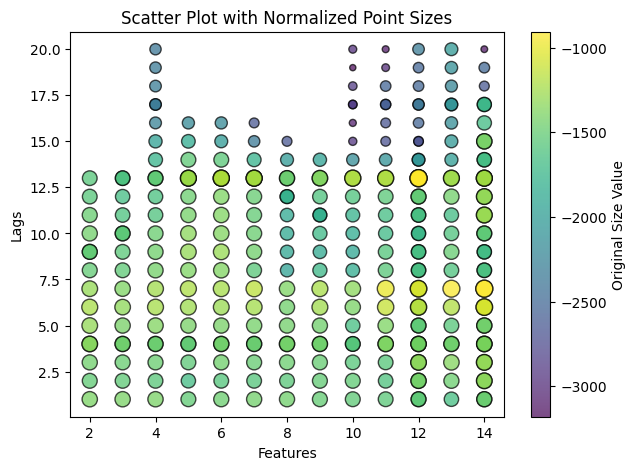

In [21]:
# Normalize sizes to a reasonable range for visualization
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the results
results = pd.read_csv('feature_selection.csv')

scaler = MinMaxScaler(feature_range=(20, 150))  # Adjust range as needed
sizes_normalized = scaler.fit_transform(results["Relative_RMSE"].values.reshape(-1, 1)).flatten()

# Create scatter plot
plt.figure(figsize=(7, 5))
plt.scatter(results["Features"], results["Lags"], s=sizes_normalized, c=results["Relative_RMSE"], cmap='viridis', alpha=0.7, edgecolors="k")

# Labels & Title
plt.xlabel("Features")
plt.ylabel("Lags")
plt.title("Scatter Plot with Normalized Point Sizes")
plt.colorbar(label="Original Size Value")
plt.show()